<a href="https://colab.research.google.com/github/Farmhouse121/Wilmott-Articles/blob/main/Do_the_Right_Thing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
print("Installing yfinance and arch and getting the data...")
!pip install arch 1>/dev/null
!pip install yfinance 1>/dev/null
from warnings import filterwarnings ; filterwarnings('ignore',category=FutureWarning) # I don't care
from yfinance import download
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from statsmodels.regression.linear_model import OLS
from statsmodels.api import add_constant
from arch.univariate import ARX, GARCH, GeneralizedError
from datetime import datetime
from scipy.stats import chi2 as density
zero,one,two,four,three,five,ten,hundred=0e0,1e0,2e0,3e0,4e0,5e0,1e1,1e2 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two

# get the daily returns from Yahoo! Finance
ticker='DIA'
data=download(ticker,'1999-03-11','2019-12-31')
data.index=pd.DatetimeIndex(data.index).to_period('B')  # set calendar to business days
data['Return']=data['Adj Close'].pct_change()*hundred   # compute returns including dividends and splits etc.
data['LagReturn']=data['Return'].shift()                # compute returns lagged by one trading day
data.dropna(inplace=True)                               # remove any dates that are not properly 'bars', often due to holidays not properly removed
data.loc[data["Volume"]==0,"Volume"]=np.nan             # change zero volume to NA should it exist
in_sample,out_sample=data.loc[data.index<='2009-12-31'].copy(),data.loc[data.index>='2010-01-01'].copy()
print("In sample data...")
display(in_sample)
print("Out of sample data...")
display(out_sample)

Installing yfinance and arch and getting the data...
[*********************100%***********************]  1 of 1 completed
In sample data...


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


,Open,High,Low,Close,Adj Close,Volume,Return,LagReturn
Date,,,,,,,,
1999-03-15,50.437500,51.562500,49.906250,51.500000,44.388470,6369000.0,2.871447,-2.436102
1999-03-16,51.718750,52.156250,51.156250,51.937500,44.765560,4905800.0,0.849523,2.871447
1999-03-17,51.937500,52.000000,51.406250,51.562500,44.442322,3965000.0,-0.722069,0.849523
1999-03-18,51.500000,52.593750,51.484375,52.562500,45.304260,4848400.0,1.939454,-0.722069
1999-03-19,53.250000,53.250000,51.187500,51.218750,44.146057,7160400.0,-2.556499,1.939454
...,...,...,...,...,...,...,...,...
2009-12-24,45.610001,45.980000,45.599998,45.980000,40.777073,31770400.0,0.921862,0.729675
2009-12-28,46.090000,46.299999,45.939999,46.220001,40.989895,49381400.0,0.521916,0.921862
2009-12-29,46.230000,46.250000,45.990002,46.029999,40.821392,32410200.0,-0.411084,0.521916


Out of sample data...


,Open,High,Low,Close,Adj Close,Volume,Return,LagReturn
Date,,,,,,,,
2010-01-04,46.330002,46.490002,46.270000,46.419998,41.167278,62822800.0,1.464480,-0.909655
2010-01-05,46.389999,46.500000,46.160000,46.419998,41.167278,62935600.0,0.000000,1.464480
2010-01-06,46.400002,46.549999,46.070000,46.139999,40.918957,96033000.0,-0.603201,0.000000
2010-01-07,46.209999,46.270000,45.919998,46.169998,40.945557,77094100.0,0.065006,-0.603201
2010-01-08,46.070000,46.549999,45.930000,46.549999,41.282558,88886600.0,0.823049,0.065006
...,...,...,...,...,...,...,...,...
2019-12-23,212.000000,212.149994,211.630005,211.809998,208.565872,23774700.0,0.264125,0.403113
2019-12-24,212.000000,212.089996,211.440002,211.919998,208.674225,7089000.0,0.051951,0.264125
2019-12-26,212.259995,213.809998,212.229996,213.789993,210.515549,17067500.0,0.882392,0.051951


In [17]:
print("Fitting AR(1) model to %s Returns in sample...\n" % ticker)
ols_model=OLS(in_sample['Return'],add_constant(in_sample['LagReturn'])).fit()
print(ols_model.summary())
print("IC = %g." % np.sqrt(ols_model.rsquared))

Fitting AR(1) model to QQQ Returns in sample...

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.782
Date:                Thu, 20 Oct 2022   Prob (F-statistic):             0.0289
Time:                        15:01:22   Log-Likelihood:                -5957.3
No. Observations:                2719   AIC:                         1.192e+04
Df Residuals:                    2717   BIC:                         1.193e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

In [35]:
print("Fitting AR(1)xAGARCH(1,1) model with GED innovations to Returns in sample...\n")
model = ARX(in_sample["Return"],lags=1)
model.volatility = GARCH(1, 1, 1)
model.distribution = GeneralizedError()
ged_model=model.fit(update_freq=0)
print(ged_model.summary())
print("IC = %g." % np.sqrt(ged_model.rsquared))

from scipy.stats import chi2 as density
X2,dof=two*(ged_model.loglikelihood-ols_model.llf),len(ged_model.params)-len(ols_model.params)-1 # extra one for the variance
print("\nMaximum Likelihood Ratio Test vs OLS Model\nχ²(%d) = %f, p value = %g" % (dof,X2,one-density(dof).cdf(X2)))

Fitting AR(1)xAGARCH(1,1) model with GED innovations to Returns in sample...

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5244.129806110366
            Iterations: 20
            Function evaluations: 184
            Gradient evaluations: 20
                               AR - GJR-GARCH Model Results                               
Dep. Variable:                             Return   R-squared:                       0.001
Mean Model:                                    AR   Adj. R-squared:                  0.001
Vol Model:                              GJR-GARCH   Log-Likelihood:               -5244.13
Distribution:      Generalized Error Distribution   AIC:                           10502.3
Method:                        Maximum Likelihood   BIC:                           10543.6
                                                    No. Observations:                 2718
Date:                            Thu, Oct 20 2022   Df Residuals:          

Compute out-of-sample alphas for both models.


,Open,High,Low,Close,Adj Close,Volume,Return,LagReturn,OLS Alpha,GED Alpha
Date,,,,,,,,,,
2010-01-04,46.330002,46.490002,46.270000,46.419998,41.167278,62822800.0,1.464480,-0.909655,0.060083,0.073522
2010-01-05,46.389999,46.500000,46.160000,46.419998,41.167278,62935600.0,0.000000,1.464480,-0.039407,0.019764
2010-01-06,46.400002,46.549999,46.070000,46.139999,40.918957,96033000.0,-0.603201,0.000000,0.021963,0.052924
2010-01-07,46.209999,46.270000,45.919998,46.169998,40.945557,77094100.0,0.065006,-0.603201,0.047241,0.066583
2010-01-08,46.070000,46.549999,45.930000,46.549999,41.282558,88886600.0,0.823049,0.065006,0.019239,0.051452
...,...,...,...,...,...,...,...,...,...,...
2019-12-23,212.000000,212.149994,211.630005,211.809998,208.565872,23774700.0,0.264125,0.403113,0.005070,0.043797
2019-12-24,212.000000,212.089996,211.440002,211.919998,208.674225,7089000.0,0.051951,0.264125,0.010895,0.046944
2019-12-26,212.259995,213.809998,212.229996,213.789993,210.515549,17067500.0,0.882392,0.051951,0.019786,0.051748


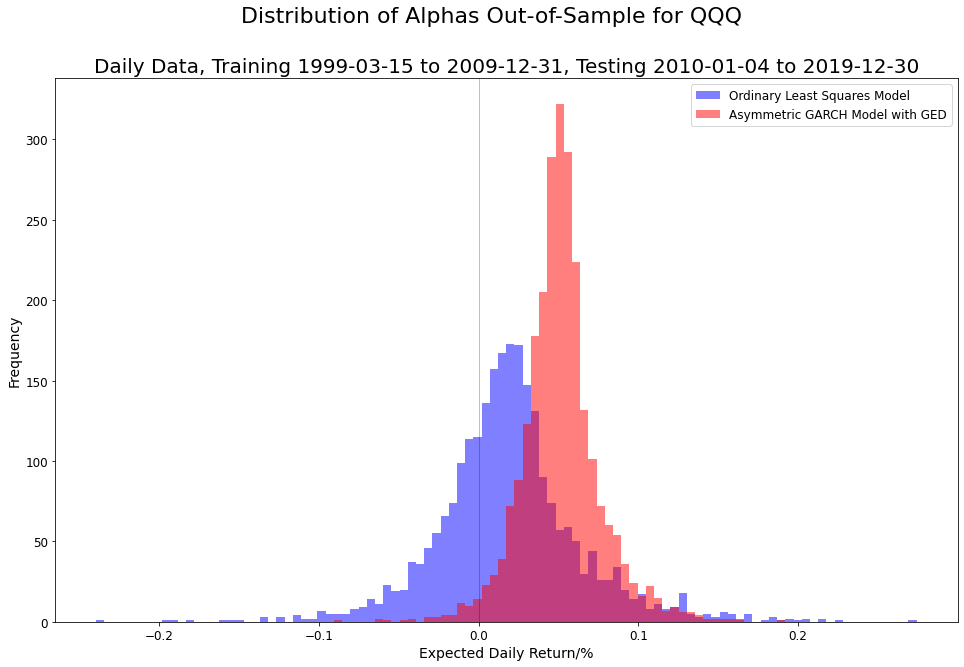

In [19]:
print("Compute out-of-sample alphas for both models.")
out_sample['OLS Alpha']=ols_model.params[0]+ols_model.params[1]*out_sample['LagReturn']
out_sample['GED Alpha']=ged_model.params[0]+ged_model.params[1]*out_sample['LagReturn']
display(out_sample)

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
sample,bins,patches=plot.hist(out_sample['OLS Alpha'],
                              bins=np.linspace(out_sample[['OLS Alpha','GED Alpha']].min().min(),out_sample[['OLS Alpha','GED Alpha']].max().max(),101),
                              color='blue',alpha=0.5,label='Ordinary Least Squares Model')
sample,bins,patches=plot.hist(out_sample['GED Alpha'],
                              bins=np.linspace(out_sample[['OLS Alpha','GED Alpha']].min().min(),out_sample[['OLS Alpha','GED Alpha']].max().max(),101),
                              color='red',alpha=0.5,label='Asymmetric GARCH Model with GED')
title='Distribution of Alphas Out-of-Sample for %s' % ticker
subtitle='Daily Data, Training %s to %s, Testing %s to %s' % (in_sample.index[0],in_sample.index[-1],out_sample.index[0],out_sample.index[-1])
figure.suptitle(title,fontsize=22)
plot.set_title(subtitle,fontsize=20)
plot.legend(fontsize=12)
plot.set_xlabel('Expected Daily Return/%',fontsize=14)
plot.set_ylabel('Frequency',fontsize=14)
plot.tick_params(labelsize=12)
plot.axvline(color='black',linewidth=1,alpha=0.25)
figure.savefig(title+".png",dpi=300);

Simulate trading out of sample for both alphas. Assuming zero transaction costs...
Basic Summary Data:


,Sample,Mean,StDev,Kurtosis,IC,Sharpe,StdErr
Model,,,,,,,
OLS,2515.0,0.040697,1.088846,6.978033,2.57305,0.593327,0.316982
GED,2515.0,0.070524,1.087321,7.068110,2.57305,1.029630,0.317886



Test for Sharpe Ratio Consistency
χ² = 1.88379, d.o.f. = 1, p Value = 0.169904

Leverage of Improvements
Q = 1.37446


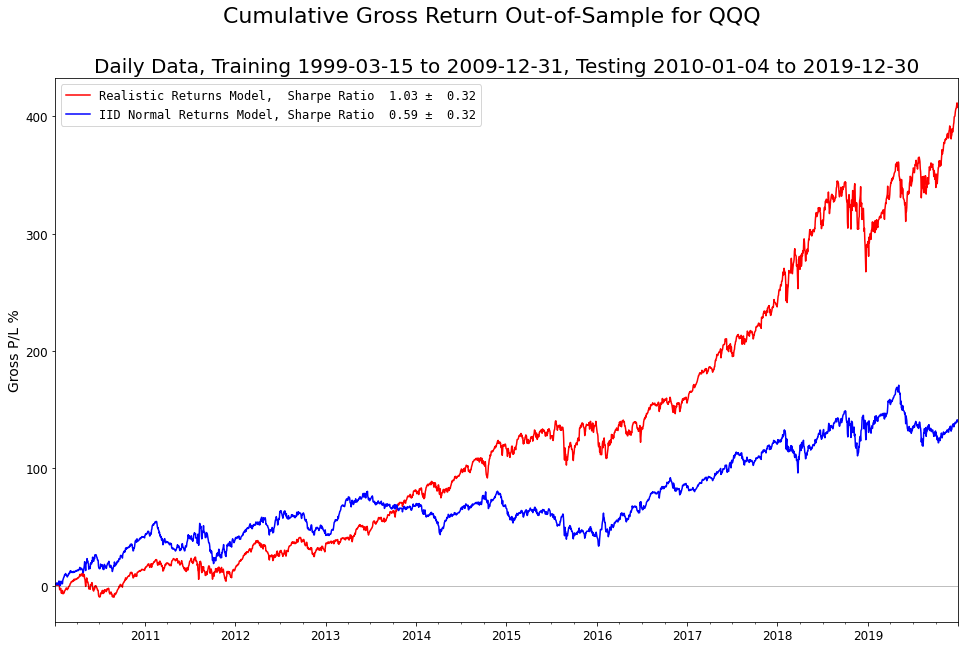

In [20]:
print("Simulate trading out of sample for both alphas. Assuming zero transaction costs...")
stats,annualize=pd.DataFrame({'Model':[],'Sample':[],'Mean':[],'StDev':[],'Kurtosis':[],'IC':[],'Sharpe':[],'StdErr':[]}).set_index('Model'),252e0

for prefix in 'OLS','GED':
    out_sample["%s Holding" % prefix]=np.sign(out_sample["%s Alpha" % prefix]) # note, alpha was known at end of prior day, assumes position established then
    out_sample["%s Gross P/L" % prefix]=out_sample["Return"]*out_sample["%s Holding" % prefix] # return today on position established yesterday
    out_sample["%s Total P/L" % prefix]=np.exp(np.cumsum(np.log(one+out_sample["%s Gross P/L" % prefix]/hundred)))*hundred-hundred # compute compounded P/L
    stats.loc[prefix,"Sample"]=out_sample["%s Gross P/L" % prefix].count()    
    stats.loc[prefix,"Mean"]=out_sample["%s Gross P/L" % prefix].mean()
    stats.loc[prefix,"StDev"]=out_sample["%s Gross P/L" % prefix].std()
    stats.loc[prefix,"Kurtosis"]=out_sample["%s Gross P/L" % prefix].kurt()+three # function as specificed returns the adjusted kurtosis
    stats.loc[prefix,"IC"]=out_sample[["Return","%s Alpha" % prefix]].corr().iloc[0,1]*hundred

stats["Sharpe"]=stats["Mean"]/stats["StDev"]*np.sqrt(annualize) # yeah, no risk free rate but its basically been zero for this entire period, 252 trading days per year in US
stats["StdErr"]=np.sqrt(annualize/stats["Sample"]*(one+(stats["Kurtosis"]-one)/(four*annualize)*stats["Sharpe"]**2)) # standard error of Sharpe Ratio with kurtosis

print("Basic Summary Data:")
display(stats)

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
out_sample['GED Total P/L'].plot(ax=plot,color='Red',label='Realistic Returns Model,  Sharpe Ratio %5.2f ± % 5.2f' % (stats.loc['GED','Sharpe'],stats.loc['GED','StdErr']))
out_sample['OLS Total P/L'].plot(ax=plot,color='Blue',label='IID Normal Returns Model, Sharpe Ratio %5.2f ± % 5.2f' % (stats.loc['OLS','Sharpe'],stats.loc['OLS','StdErr']))
title='Cumulative Gross Return Out-of-Sample for %s' % ticker
subtitle='Daily Data, Training %s to %s, Testing %s to %s' % (in_sample.index[0],in_sample.index[-1],out_sample.index[0],out_sample.index[-1])
figure.suptitle(title,fontsize=22)
plot.set_title(subtitle,fontsize=20)
plot.set_xlabel(None)
plot.set_ylabel('Gross P/L %',fontsize=14)
plot.tick_params(labelsize=12)
plot.axhline(color='black',linewidth=1,alpha=0.25)
pl.setp(plot.legend(loc='upper left',fontsize=12).texts,family='monospace');
figure.savefig(title+".png",dpi=300)

chi2,dof=(stats.loc['GED','Sharpe']-stats.loc['OLS','Sharpe'])**2/(stats['StdErr'].max()**2),1
print("\nTest for Sharpe Ratio Consistency\nχ² = %g, d.o.f. = %d, p Value = %g" % (chi2,dof,one-density.cdf(chi2,dof)))
print("\nLeverage of Improvements\nQ = %g" % ((stats["Sharpe"].max()-stats["Sharpe"].min())/(np.sqrt((stats['StdErr']**2).sum()/two))))